In [249]:
import pyspark
from pyspark.sql import SQLContext
from pyspark.sql.types import *
import pyspark.sql.functions as func
from pyspark.sql.functions import col
from pyspark.sql.functions import sum
from pyspark.sql.functions import when
from pyspark.sql.functions import explode
from pyspark.sql.functions import unix_timestamp, month, date_format, from_unixtime
import datetime

In [156]:
unix_timestamp?

In [3]:
sc = pyspark.SparkContext(appName="TrendAnalysis")
sqlContext = SQLContext(sc)

In [44]:
posts = sqlContext.read.parquet("./data/results/Posts_clean_parquet/Posts.parquet")
# tags_df=df \
# .select(df["Id"].cast('int'), 
#         df["Tags"], 
#         df["CreationDate"].cast('date'), 
#         df['LastEditDate'].cast('date'))
posts.limit(5).toPandas()

,Id,Tags,CreationDate,LastEditDate
0,1,[mysql],2011-01-03,2017-05-26
1,2,[mysql],2011-01-03,2011-01-06
2,5,[mongodb],2011-01-03,2011-01-06
3,6,[postgres],2011-01-03,2011-08-16
4,14,[mysql],2011-01-03,2011-08-16


In [45]:
posts.filter('Id=96').limit(1).toPandas()

,Id,Tags,CreationDate,LastEditDate
0,96,"[postgres, mysql]",2011-01-04,2011-08-16


In [46]:
posts=posts.select('Id', explode(col('Tags')).alias('Tag'), 'CreationDate', 'LastEditDate')

In [47]:
posts.filter('Id > 93 AND Id < 98').limit(8).toPandas()

,Id,Tag,CreationDate,LastEditDate
0,94,mysql,2011-01-04,2017-05-26
1,96,postgres,2011-01-04,2011-08-16
2,96,mysql,2011-01-04,2011-08-16


In [77]:
posts_for_df=posts.filter('Tag = "sql-server"') \
.filter("CreationDate < cast('2017-01-01' as date)") \
.filter("CreationDate > cast('2011-01-01' as date)") \
.select('CreationDate').sort(col('CreationDate'))

In [136]:
posts_aggr=posts.filter('Tag = "sql-server"') \
.filter("CreationDate < cast('2017-01-01' as date)") \
.filter("CreationDate > cast('2011-01-01' as date)") \
.select('CreationDate') \
.groupBy(date_format('CreationDate', 'YYYY-MM') \
                                .alias('CreationMonth')) \
.agg({'CreationDate' : 'count'}) \
.select(col('CreationMonth').cast('date'), col('count(CreationDate)') \
        .alias('PostCount')) \
.orderBy('CreationMonth')

In [137]:
posts_aggr.dtypes

[('CreationMonth', 'date'), ('PostCount', 'bigint')]

In [78]:
posts_for_df.show(10)

+------------+
|CreationDate|
+------------+
|  2011-01-03|
|  2011-01-03|
|  2011-01-03|
|  2011-01-03|
|  2011-01-04|
|  2011-01-04|
|  2011-01-04|
|  2011-01-04|
|  2011-01-04|
|  2011-01-04|
+------------+
only showing top 10 rows



In [55]:
posts_for_df.filter("CreationDate < cast('2015-12-01' as date)") \
.filter("CreationDate > cast('2015-11-01' as date)").select('CreationDate').count()

373

In [79]:
df=posts_for_df.toPandas()

In [80]:
df[:5]

,CreationDate
0,2011-01-03
1,2011-01-03
2,2011-01-03
3,2011-01-03
4,2011-01-04


In [15]:
import pandas as pd
from matplotlib import pyplot
%matplotlib inline

In [81]:
df['CreationDate']=pd.to_datetime(df['CreationDate'], format= '%Y-%m-%d')
df.dtypes
# dt.datetime.strptime(d,'%m/%d/%Y').date()

CreationDate    datetime64[ns]
dtype: object

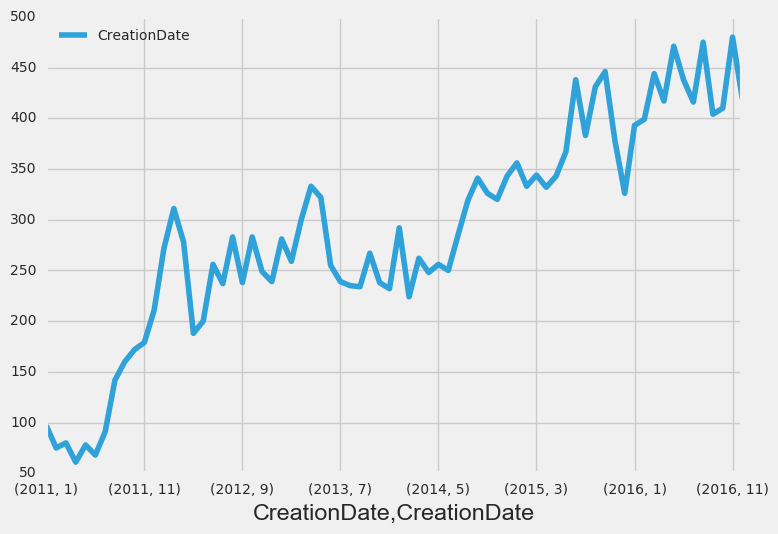

In [87]:
# df.groupby([df["CreationDate"].dt.year, df["CreationDate"].dt.month]).count().plot(kind="bar")

# df \
# .groupby([df["CreationDate"].dt.year, df["CreationDate"].dt.month]) \
# .count().plot(kind="line")

# .select("Id", "CreationDate") \
# .groupby(df["CreationDate"].dt.year).count().plot(kind="bar")

In [82]:
pyplot.hist([1,11,21,31,41], bins=[0,10,20,30,40,50], weights=[10,1,40,33,6]);

KeyError: 'Id'

In [18]:
from matplotlib import pyplot as plt 
import seaborn as sns
plt.style.use('fivethirtyeight')

In [ ]:
# df \
# .groupby([df["CreationDate"].dt.year, df["CreationDate"].dt.month]).count().plot(kind="line")
# df \
# .groupby(df["CreationDate"].dt.year).count().plot(kind="bar")
df1 = posts_aggr.toPandas()

In [130]:
posts_aggr.take(10)

[Row(CreationMonth='2011-01', PostCount=97),
 Row(CreationMonth='2011-02', PostCount=75),
 Row(CreationMonth='2011-03', PostCount=80),
 Row(CreationMonth='2011-04', PostCount=61),
 Row(CreationMonth='2011-05', PostCount=78),
 Row(CreationMonth='2011-06', PostCount=68),
 Row(CreationMonth='2011-07', PostCount=91),
 Row(CreationMonth='2011-08', PostCount=142),
 Row(CreationMonth='2011-09', PostCount=160),
 Row(CreationMonth='2011-10', PostCount=172)]

In [138]:
df1['CreationMonth']=pd.to_datetime(df1['CreationMonth'], format= '%Y-%m')

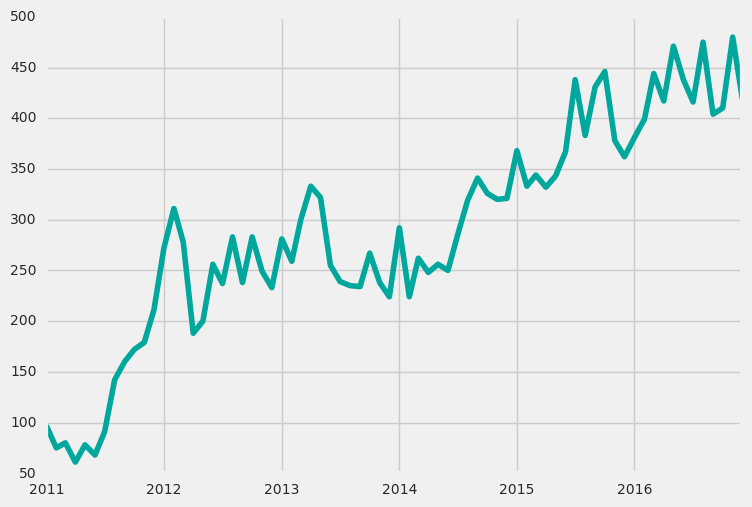

In [322]:
plt.plot(df1.CreationMonth, df1.PostCount, color = '#00a79c')

In [160]:
posts_aggr_cast=posts_aggr \
.select(col('CreationMonth'), col('PostCount')) \
.withColumn(
    'CreationMonth', unix_timestamp(posts_aggr.CreationMonth, 'yyyy-MM-dd'))
posts_aggr_cast.show()

+-------------+---------+
|CreationMonth|PostCount|
+-------------+---------+
|   1293836400|       97|
|   1296514800|       75|
|   1298934000|       80|
|   1301608800|       61|
|   1304200800|       78|
|   1306879200|       68|
|   1309471200|       91|
|   1312149600|      142|
|   1314828000|      160|
|   1317420000|      172|
|   1320102000|      179|
|   1322694000|      211|
|   1325372400|      272|
|   1328050800|      311|
|   1330556400|      278|
|   1333231200|      188|
|   1335823200|      200|
|   1338501600|      256|
|   1341093600|      237|
|   1343772000|      283|
+-------------+---------+
only showing top 20 rows



In [161]:
posts_aggr_cast.dtypes

[('CreationMonth', 'bigint'), ('PostCount', 'bigint')]

In [ ]:
from pyspark.ml.feature import VectorAssembler
t = VectorAssembler(inputCols=['CreationMonth'], outputCol = 'features')
training = t.transform(posts_aggr_cast)\
            .withColumn('CreationMonth',posts_aggr_cast.CreationMonth)\
            .withColumn('label',posts_aggr_cast.PostCount)
        

In [237]:
training.toPandas()

,CreationMonth,PostCount,features,label
0,1293836400,97,[1293836400.0],97
1,1296514800,75,[1296514800.0],75
2,1298934000,80,[1298934000.0],80
3,1301608800,61,[1301608800.0],61
4,1304200800,78,[1304200800.0],78
5,1306879200,68,[1306879200.0],68
6,1309471200,91,[1309471200.0],91
7,1312149600,142,[1312149600.0],142
8,1314828000,160,[1314828000.0],160
9,1317420000,172,[1317420000.0],172


In [163]:
from pyspark.sql.types import Row

# apply model for the 1979-80 season thru 2020-21 season
training_yrs = training.select('CreationMonth').rdd.map(lambda x: x[0]).collect()
training_y = training.select('PostCount').rdd.map(lambda x: x[0]).collect()

In [203]:
datetime.?

In [273]:
import calendar
prediction_yrs=[]
for i in range(36):
    yrs = 2017 + int(i/12)
    mths = i%12 + 1
    prediction_yrs \
    .append(calendar.timegm(datetime.date(yrs,mths,1).timetuple()))

In [1]:
# prediction_yrs = [2017, 2018, 2019, 2020, 2021]
all_yrs = training_yrs + prediction_yrs

NameError: name 'training_yrs' is not defined

In [231]:
from pyspark.ml.regression import LinearRegression
lr = LinearRegression(maxIter=10, regParam=0.3, elasticNetParam=0.8)
lrModel = lr.fit(training)

In [280]:
# built testing DataFrame
test_rdd = sc.parallelize(all_yrs)
row = Row('CreationMonth')
all_years_features = t.transform(test_rdd.map(row).toDF())

In [296]:
# import pyspark.ml as ml
# apply linear regression model
df_results = lrModel.transform(all_years_features).toPandas()

In [297]:
df_results.count()

CreationMonth    108
features         108
prediction       108
dtype: int64

In [298]:
df_results

,CreationMonth,features,prediction
0,1293836400,[1293836400.0],124.707599
1,1296514800,[1296514800.0],129.401422
2,1298934000,[1298934000.0],133.641003
3,1301608800,[1301608800.0],138.328517
4,1304200800,[1304200800.0],142.870925
5,1306879200,[1306879200.0],147.564748
6,1309471200,[1309471200.0],152.107156
7,1312149600,[1312149600.0],156.800979
8,1314828000,[1314828000.0],161.494801
9,1317420000,[1317420000.0],166.037210


In [299]:
# import numpy as np
# m = np.asarray(all_yrs)
# m.ndim

# df_results['timestamp'] = m[df_results['prediction']]
# df_results

In [305]:
pd.to_datetime?

In [320]:
df_results_casted=df_results
df_results_casted['CreationMonth']=df_results['CreationMonth']=pd.to_datetime(
    df_results['CreationMonth'], unit='s')
# from_unixtime(unix_timestamp(df_results['CreationMonth']), 'YYYY-MM')
df_results_casted['CreationMonth']=pd.to_datetime(df_results_casted['CreationMonth'], format= '%Y-%m')
df_results_casted

,CreationMonth,features,prediction
0,2010-12-31 23:00:00,[1293836400.0],124.707599
1,2011-01-31 23:00:00,[1296514800.0],129.401422
2,2011-02-28 23:00:00,[1298934000.0],133.641003
3,2011-03-31 22:00:00,[1301608800.0],138.328517
4,2011-04-30 22:00:00,[1304200800.0],142.870925
5,2011-05-31 22:00:00,[1306879200.0],147.564748
6,2011-06-30 22:00:00,[1309471200.0],152.107156
7,2011-07-31 22:00:00,[1312149600.0],156.800979
8,2011-08-31 22:00:00,[1314828000.0],161.494801
9,2011-09-30 22:00:00,[1317420000.0],166.037210


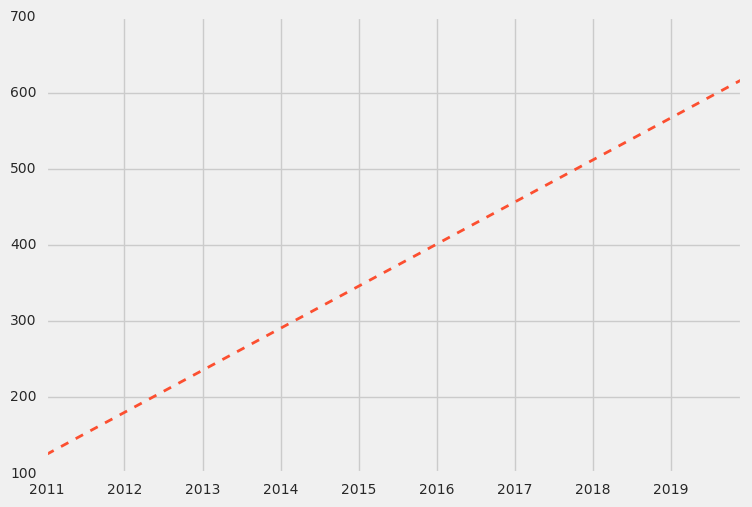

In [321]:
plt.plot(
    df_results_casted.CreationMonth,
    df_results_casted.prediction, 
    linewidth = 2, 
    linestyle = '--',
    color = '#fc4f30', 
    label = 'L2 Fit')

In [ ]:
df1.PostCount

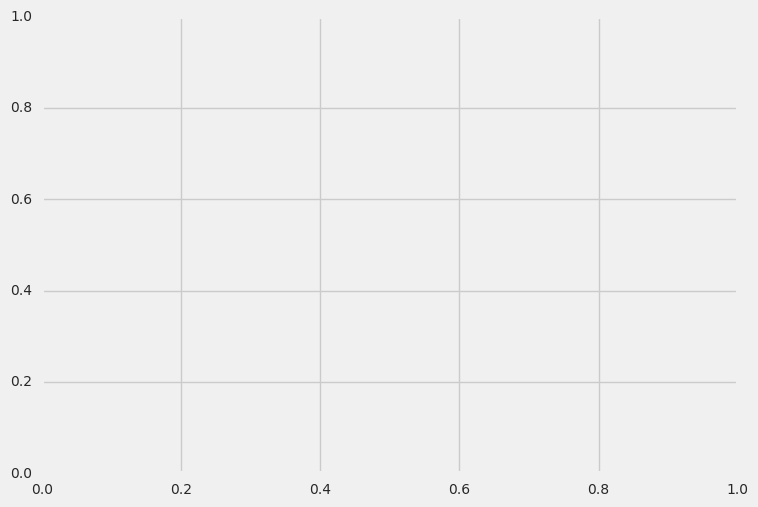

In [324]:
ax = df1.CreationMonth
fig, ax = plt.subplots()

C:\Users\rpasz\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


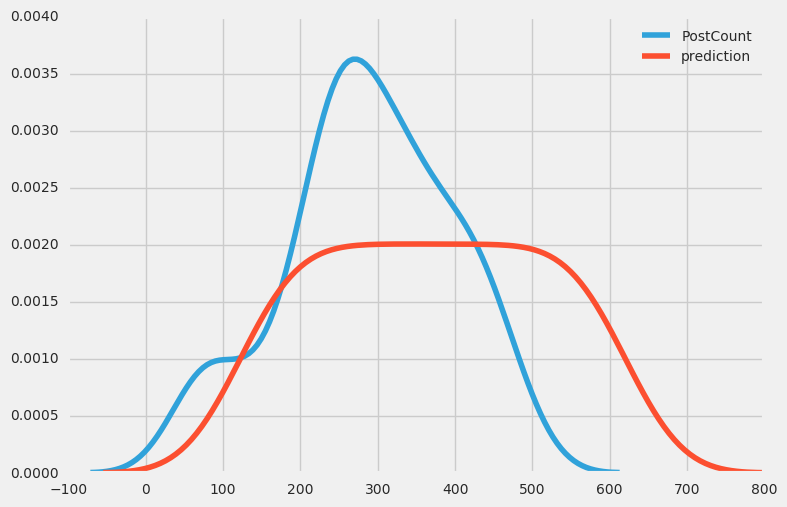

In [332]:
# import seaborn
# ax = df1.CreationMonth
# fig, ax = plt.subplots()
seaborn.kdeplot(df1.PostCount)
seaborn.kdeplot(df_results_casted.prediction)

In [221]:
ml.Model.transform?

In [ ]:
from pyspark.ml.regression import LinearRegression

# Load training data
training = posts_aggr
# training = spark.read.format("libsvm")\
#     .load("data/mllib/sample_linear_regression_data.txt")

lr = LinearRegression(maxIter=10, regParam=0.3, elasticNetParam=0.8)

# Fit the model
lrModel = lr.fit(training)

# Print the coefficients and intercept for linear regression
print("Coefficients: %s" % str(lrModel.coefficients))
print("Intercept: %s" % str(lrModel.intercept))

# Summarize the model over the training set and print out some metrics
trainingSummary = lrModel.summary
print("numIterations: %d" % trainingSummary.totalIterations)
print("objectiveHistory: %s" % str(trainingSummary.objectiveHistory))
trainingSummary.residuals.show()
print("RMSE: %f" % trainingSummary.rootMeanSquaredError)
print("r2: %f" % trainingSummary.r2)